In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.constraints import maxnorm
import keras.backend as K

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from plot import plot_confusion_matrix_a

from tests import train_test_split_intime_smote
from tests import train_test_split_intime_resample
from tests import train_test_split_intime_adasyn

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

Using TensorFlow backend.


In [2]:
df_train = pd.read_pickle('data_train.pkl')
df_test = pd.read_pickle('data_test.pkl')

In [3]:
target = ['discretize_s4', ]
predictors = [i for i in df_train.columns if i not in target]
score_function = accuracy_score

In [4]:
class MLPKeras():
    def __init__(self, n_epoches, batch_size):
        self._n_epoches = n_epoches
        self._batch_size = batch_size
        self._model = Sequential()
        #self._model.add(Dropout(0.4, input_shape=(13,)))
        self._model.add(Dense(units=13, input_shape=(13,), activation='relu', init='uniform', W_constraint=maxnorm(5)))
        #self._model.add(Dropout(0.4))
        self._model.add(Dense(units=26, activation='relu', init='uniform', W_constraint=maxnorm(5)))
        self._model.add(Dropout(0.4))
        self._model.add(Dense(units=26, activation='relu', init='uniform', W_constraint=maxnorm(5)))
        #self._model.add(Dropout(0.4))
        self._model.add(Dense(units=13, activation='relu', init='uniform', W_constraint=maxnorm(5)))
        self._model.add(Dense(units=1, activation='sigmoid', init='uniform', W_constraint=maxnorm(5)))
        #sgd=SGD(lr=0.1, momentum=0.9, decay=0.00005, nesterov=False)
        self._model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    def fit(self, X, y, eval_set=None):
        history = self._model.fit(X, y, 
                                  validation_data=eval_set, 
                                  epochs=self._n_epoches, 
                                  batch_size=self._batch_size, 
                                  verbose=0)
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        # summarize history for precision
        ax[0].plot(history.history['acc'], label='train')
        if eval_set is not None:
            ax[0].plot(history.history['val_acc'], label='test')
        ax[0].set_title('model acc')
        ax[0].set_ylabel('precision')
        ax[0].set_xlabel('epoches')
        ax[0].legend(loc='upper left')

        # summarize history for loss
        ax[1].plot(history.history['loss'], label='train')
        if eval_set is not None:
            ax[1].plot(history.history['val_loss'], label='test')
        ax[1].set_title('model loss')
        ax[1].set_ylabel('loss')
        ax[1].set_xlabel('epoches')
        ax[1].legend(loc='upper left')

        fig.tight_layout()
    
    def predict(self, X):
        return np.where(self._model.predict(X) > 0.5, 1, 0)
    
    def transform(self, X):
        return self.predict(X)
    
    def precision(self, y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [5]:
def test_intime(df_train, df_test,
                                   split, mod, score_function,
                                   predictors, target):

    X_train, y_train, X_test, y_test = split(df_train,
                                             df_test,
                                             predictors,
                                             target)

    # generate minmax transformation for (x,y)
    # transformation for X
    X_scaler = MinMaxScaler(feature_range=(0.05, 0.95))
    X_scaler.fit(X_train)
    X_train = X_scaler.transform(X_train)

    # get the predictors after generate pdf representation
    # then extract the data from the df_aux_1 dataframe
    # generate pdf representation to test data
    X_test = X_scaler.transform(X_test)
    
    print("Número de amostras da classe 1.0: {}".format(y_train[y_train == 1.0].shape[0]))
    print("Número de amostras da classe 0.0: {}".format(y_train[y_train == 0.0].shape[0]))
    # fit the model to the train data
    validation_data = (X_test, y_test)
    mod.fit(X_train, y_train, validation_data)
    
    # make the prediction to X_test
    predict = mod.predict(X_test)

    plot_confusion_matrix_a(y_test,
                            predict,
                            classes=['NS', 'S'],
                            title='Matriz de Confusão')

    score = score_function(y_true=y_test,
                           y_pred=predict)
    loss = 1 - score
    print(loss)

# Oversampling Glauston

### Teste básico com separação no tempo

/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=13, input_shape=(13,), activation="relu", kernel_initializer="uniform", kernel_constraint=<keras.con...)`
  import sys
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=26, activation="relu", kernel_initializer="uniform", kernel_constraint=<keras.con...)`
  if __name__ == '__main__':
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=26, activation="relu", kernel_initializer="uniform", kernel_constraint=<keras.con...)`
  # This is added back by InteractiveShellApp.init_path()
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update y

Número de amostras da classe 1.0: 1051
Número de amostras da classe 0.0: 1051
0.47058823529411764


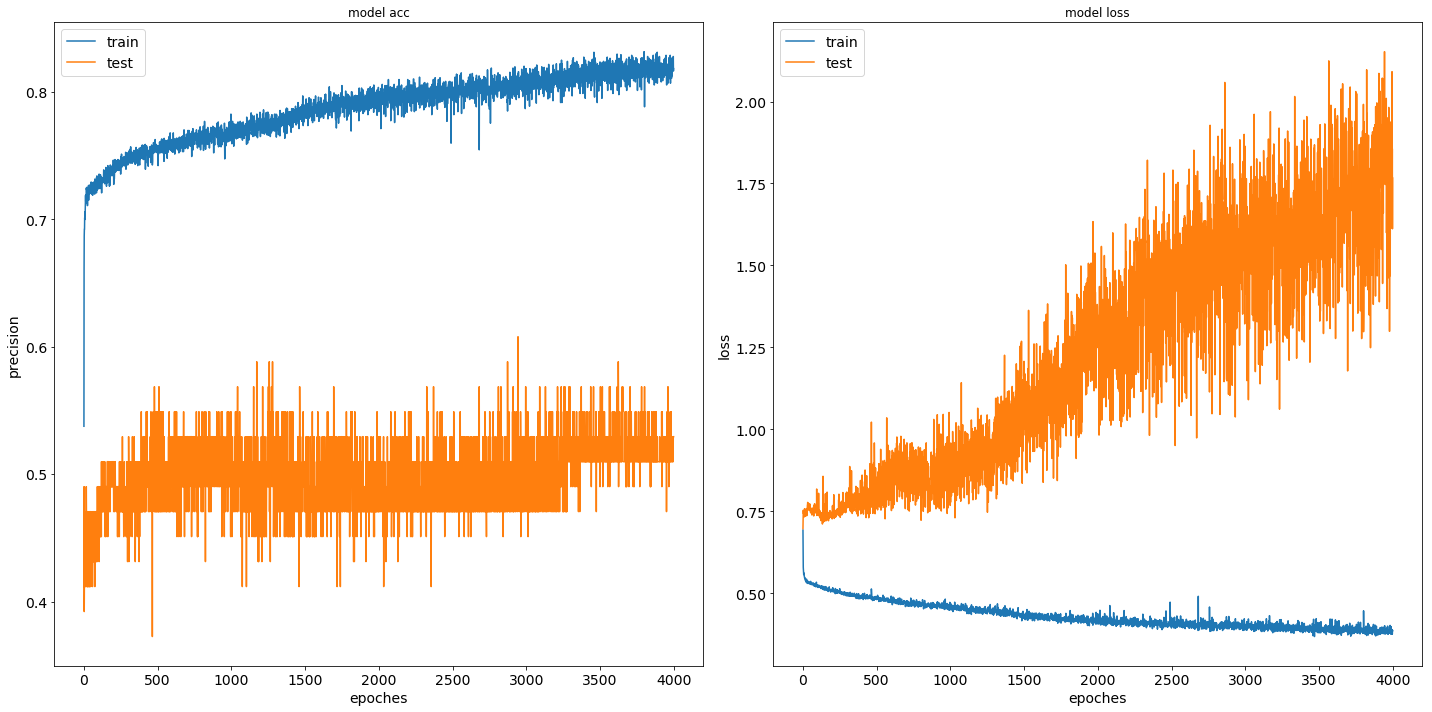

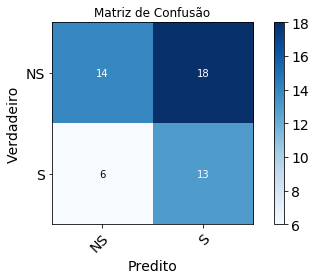

In [6]:
mlp = MLPKeras(n_epoches=4000,
               batch_size=10)

test_intime(df_train,
            df_test,
            train_test_split_intime_resample,
            mlp,
            score_function,
            predictors,
            target)

# Oversampling Smote

### Teste básico com separação no tempo

/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=13, input_shape=(13,), activation="relu", kernel_initializer="uniform", kernel_constraint=<keras.con...)`
  import sys
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=26, activation="relu", kernel_initializer="uniform", kernel_constraint=<keras.con...)`
  if __name__ == '__main__':
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=26, activation="relu", kernel_initializer="uniform", kernel_constraint=<keras.con...)`
  # This is added back by InteractiveShellApp.init_path()
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update y

Número de amostras da classe 1.0: 1051
Número de amostras da classe 0.0: 1051
0.4509803921568627


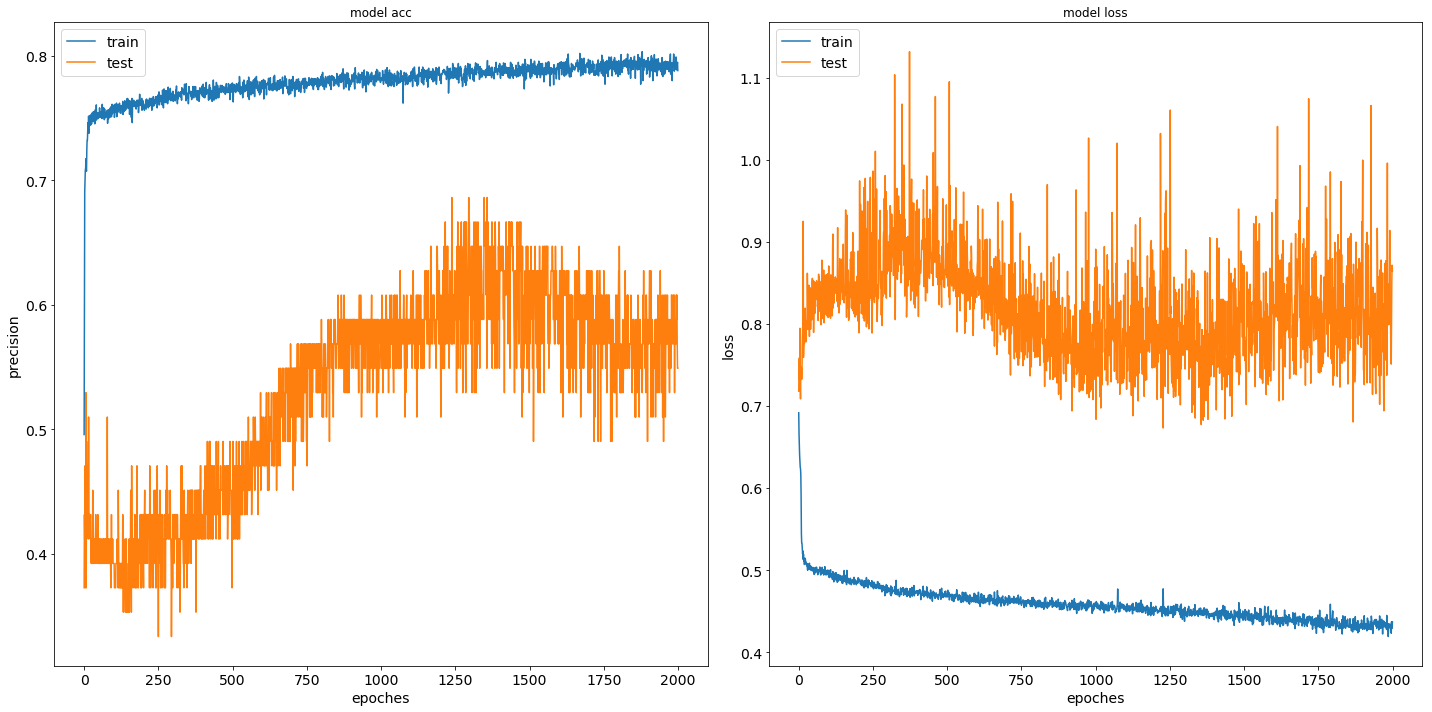

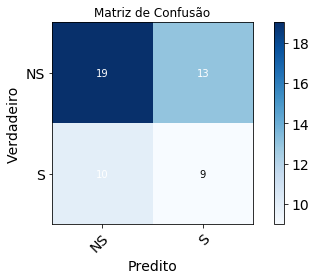

In [7]:
mlp = MLPKeras(n_epoches=2000,
               batch_size=10)

test_intime(df_train,
            df_test,
            train_test_split_intime_smote,
            mlp,
            score_function,
            predictors,
            target)

# Oversampling Adasyn

### Teste básico com separação no tempo

/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=13, input_shape=(13,), activation="relu", kernel_initializer="uniform", kernel_constraint=<keras.con...)`
  import sys
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=26, activation="relu", kernel_initializer="uniform", kernel_constraint=<keras.con...)`
  if __name__ == '__main__':
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=26, activation="relu", kernel_initializer="uniform", kernel_constraint=<keras.con...)`
  # This is added back by InteractiveShellApp.init_path()
/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update y

Número de amostras da classe 1.0: 1061
Número de amostras da classe 0.0: 1051
0.4509803921568627


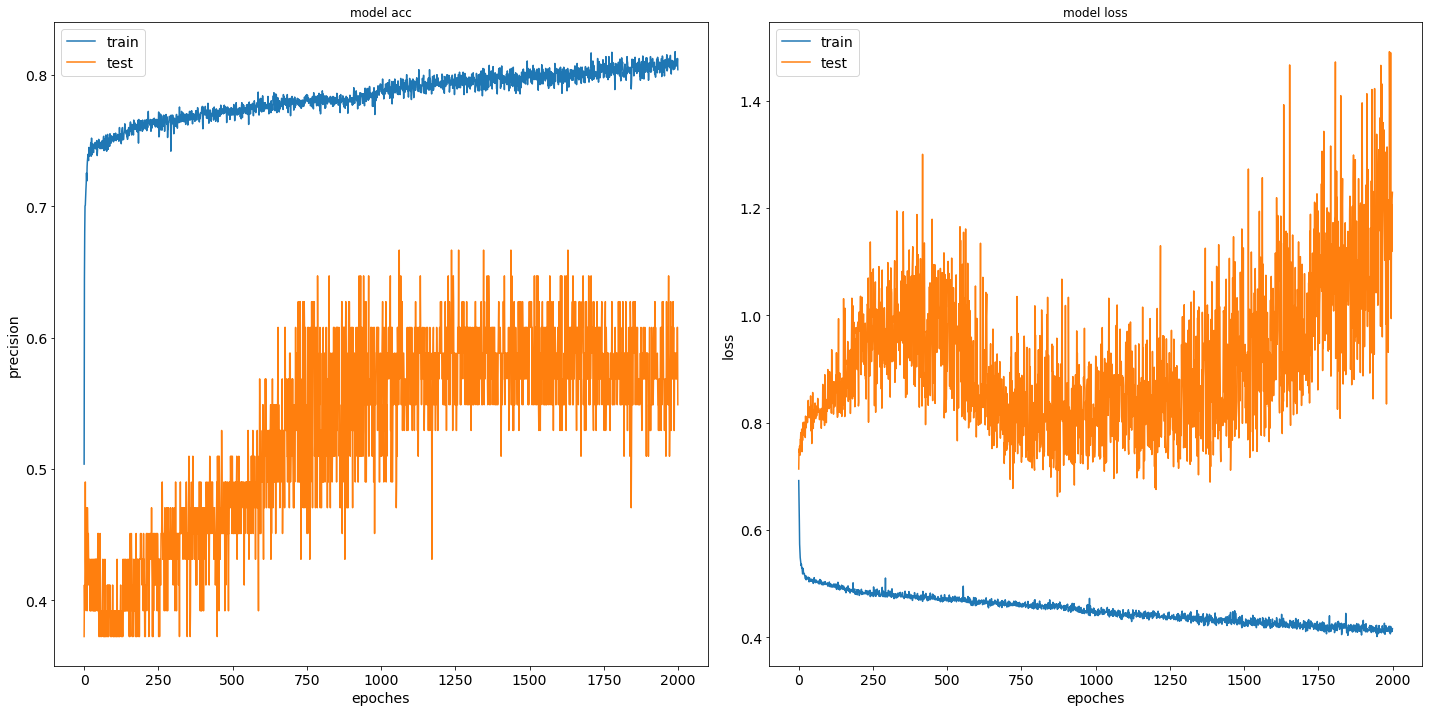

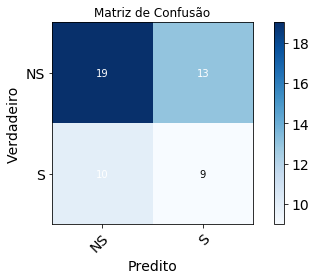

In [8]:
mlp = MLPKeras(n_epoches=2000,
               batch_size=10)

test_intime(df_train,
            df_test,
            train_test_split_intime_adasyn,
            mlp,
            score_function,
            predictors,
            target)